# Using Food.com tokenized data

Following code extracts top ingredients in descending order of their counts, as present in the Food.com dataset

In [12]:
import os
os.chdir('..')

In [ ]:
import pandas as pd
import numpy as np
import pickle
import sys
import types
from collections import Counter

import pandas.core.indexes.base
sys.modules['pandas.core.indexes.numeric'] = pandas.core.indexes.base
setattr(pandas.core.indexes.base, 'Int64Index', pd.Index)



In [14]:
from src import logger

In [15]:
# Food.com data ingestion 
import gdown
import zipfile

dataset_url = "https://drive.google.com/file/d/1M5c0pXG9onlrm0z0IlgAoFyz8C58kkFo/view?usp=sharing"
zip_download_dir = 'Data/Food.zip'
os.makedirs('../Data', exist_ok=True)
logger.info(f"Downloading data from {dataset_url} into file {zip_download_dir}")
file_id = dataset_url.split("/")[-2]
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id,zip_download_dir)

''' Extracts data from zip file '''
unzip_path = 'Data/Food'
os.makedirs(unzip_path, exist_ok=True)
with zipfile.ZipFile(zip_download_dir, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)
logger.info(f'Successfully extracted zip file to {unzip_path}')



[2025-08-17 12:58:51,929: INFO: 1020500885]: Downloading data from https://drive.google.com/file/d/1M5c0pXG9onlrm0z0IlgAoFyz8C58kkFo/view?usp=sharing into file Data/Food.zip


Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1M5c0pXG9onlrm0z0IlgAoFyz8C58kkFo
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1M5c0pXG9onlrm0z0IlgAoFyz8C58kkFo&confirm=t&uuid=594856fe-e977-4634-8ce1-0ffe968a2a7f
To: /Users/riyosha/UW_MSDS/projects/cookerooni/Data/Food.zip
100%|██████████| 280M/280M [00:02<00:00, 113MB/s]  


[2025-08-17 12:59:00,288: INFO: 1020500885]: Successfully extracted zip file to Data/Food


In [ ]:
with open("../Data/Food/ingr_map.pkl", "rb") as f:
    ingr_map = pickle.load(f, encoding="latin1")
top_ingredients = ingr_map[['replaced', 'count']].drop_duplicates(subset='replaced').sort_values(by='count', ascending=False)
top_ingredients.to_csv("../Data/Food/top_ingredients.csv", index=False)

# Recipe NLG Vector DB with ingredients

The code below creates a vector DB with FAISS from all the ingredients mentioned in a dish's recipe. 

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
recipes = pd.read_csv("../Data/RecipeNLG/RecipeNLG_dataset.csv")

/opt/anaconda3/envs/cookeroni-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
recipes['ingredients_text'] = recipes['NER'].apply(lambda x: ", ".join(eval(x)))


In [6]:
model = SentenceTransformer("all-MiniLM-L6-v2") 

embeddings = model.encode(recipes['ingredients_text'].head(50000).tolist(), 
                            batch_size=64, 
                            show_progress_bar=True,
                            convert_to_numpy=True)

# Convert to float32 for FAISS
embeddings = np.array(embeddings, dtype="float32")
embeddings = np.ascontiguousarray(embeddings)

print("Shape of embeddings:", embeddings.shape)

# Build FAISS index (L2 similarity)
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)


Batches: 100%|██████████| 782/782 [01:12<00:00, 10.80it/s]


Shape of embeddings: (50000, 384)


In [7]:
recipe_map = {
    i: {
        "title": recipes.iloc[i]["title"],
        "ingredients": recipes.iloc[i]["ingredients"],
        "directions": recipes.iloc[i]["directions"],
        "link": recipes.iloc[i]["link"]
    }
    for i in range(len(embeddings))
}

In [8]:
user_ingredients = ["chicken", "tomato", "garlic", "onion"]

query = "Recipes with " + ", ".join(user_ingredients)
query_vec = model.encode([query], convert_to_numpy=True)
query_vec = np.ascontiguousarray(query_vec, dtype=np.float32)

k = 5
distances, indices = index.search(query_vec, k)

for rank, idx in enumerate(indices[0]):
    recipe = recipe_map[idx]
    print(f"Rank {rank+1}: {recipe['title']}")
    print("Ingredients:", recipe['ingredients'])
    print("Directions:", recipe['directions'])
    print("Link:", recipe['link'])
    print("---")


Rank 1: Chicken And Rice(Low-Fat)  
Ingredients: ["4 large tomatoes", "1 large red bell pepper", "2 medium onions", "2 c. uncooked rice", "salt and pepper", "garlic powder", "1 chicken bouillon", "4 boneless breasts of chicken"]
Directions: ["Cut up tomatoes into large chunks.", "Cut up pepper into strips. Cut up onions into rings.", "Dissolve chicken bouillon with 1 cup water.", "Combine ingredients and simmer until tomatoes dissolve. Add salt, pepper and garlic powder.", "Cut up chicken in strips and add.", "Simmer another 1/2 hour.", "Cook rice and add (or) serve it over the rice."]
Link: www.cookbooks.com/Recipe-Details.aspx?id=579749
---
Rank 2: Stuffed Potatoes
Ingredients: ["10 medium size potatoes", "sausage, uncooked", "1 can tomatoes", "1 can tomato sauce", "2 c. cooked mixed vegetables", "1 medium chopped onion", "1/2 c. chopped bell pepper", "garlic to taste", "salt and pepper to taste"]
Directions: ["Peel potatoes.", "Spiral or cut out center.", "Stuff with sausage (uncook

# Food.com dataset EDA

In [22]:
import matplotlib.pyplot as plt

In [ ]:
food = pd.read_csv("../Data/Food/RAW_recipes.csv")

int64
2147483647
0


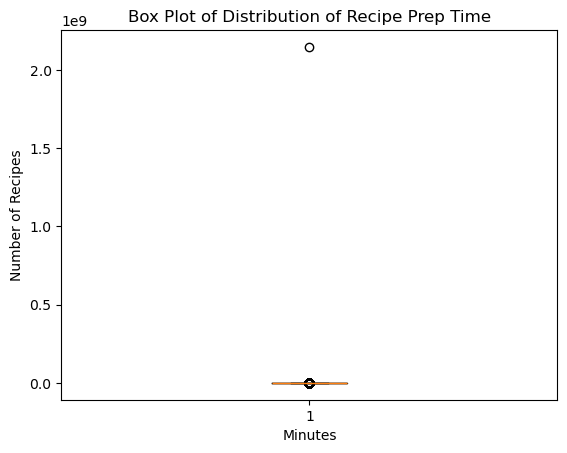

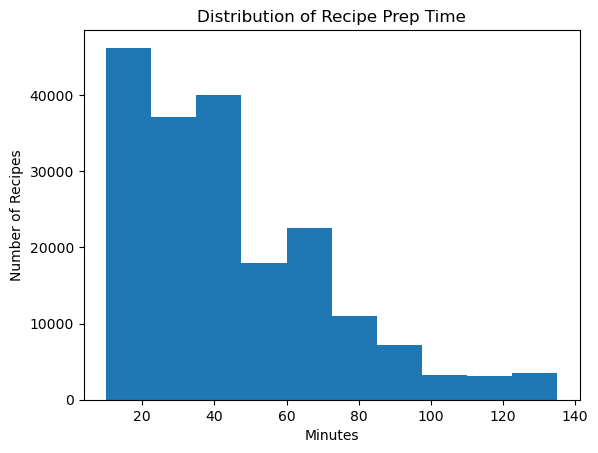

In [ ]:
# prep time distribution

print(food['minutes'].dtype)
print(max(food['minutes']))
print(min(food['minutes']))

plt.boxplot(food['minutes'])
plt.xlabel('Minutes')
plt.ylabel('Number of Recipes')
plt.title('Box Plot of Distribution of Recipe Prep Time')
plt.show()

low = food['minutes'].quantile(0.10)
high = food['minutes'].quantile(0.90)
filtered = food[(food['minutes'] >= low) & (food['minutes'] <= high)]

plt.hist(filtered['minutes'], bins=10)
plt.xlabel('Minutes')
plt.ylabel('Number of Recipes')
plt.title('Distribution of Recipe Prep Time')
plt.show()

int64
43
1


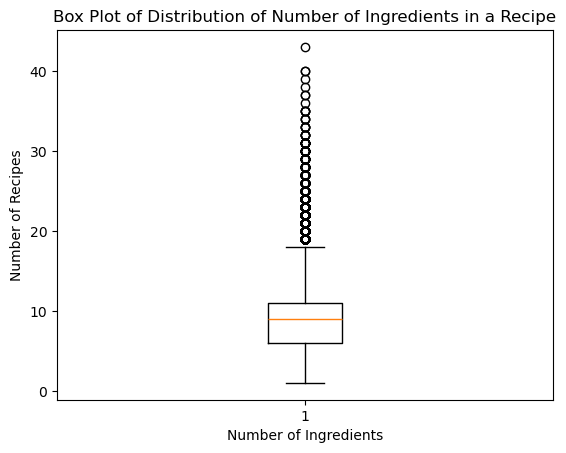

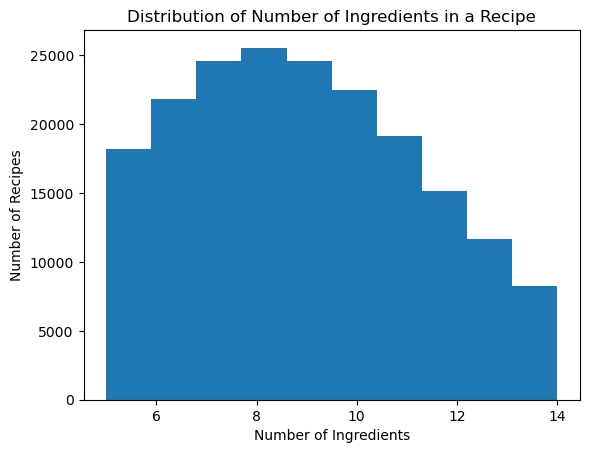

In [43]:
print(food['n_ingredients'].dtype)
print(max(food['n_ingredients']))
print(min(food['n_ingredients']))

plt.boxplot(food['n_ingredients'])
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipes')
plt.title('Box Plot of Distribution of Number of Ingredients in a Recipe')
plt.show()

low = food['n_ingredients'].quantile(0.10)
high = food['n_ingredients'].quantile(0.90)
filtered = food[(food['n_ingredients'] >= low) & (food['n_ingredients'] <= high)]

plt.hist(filtered['n_ingredients'], bins=10)
plt.xlabel('Number of Ingredients')
plt.ylabel('Number of Recipes')
plt.title('Distribution of Number of Ingredients in a Recipe')
plt.show()

# Food.com Dataset Vector DB

The code below creates a vector DB with FAISS from all the ingredients mentioned in a dish's recipe.

In [11]:
from sentence_transformers import SentenceTransformer

In [ ]:
food = pd.read_csv("../Data/Food/RAW_recipes.csv")
food_tokenized = pd.read_csv('../Data/Food/PP_recipes.csv')


Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')

In [15]:
def combine_text(row):
    ingredients = " ; ".join(eval(row['ingredients'])) if pd.notna(row['ingredients']) else ""
    steps = " ".join(eval(row['steps'])) if pd.notna(row['steps']) else ""
    return ingredients + " " + steps

food['recipe_text'] = food.apply(combine_text, axis=1)

In [44]:
model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode the recipe texts
embeddings = model.encode(
    food['recipe_text'].head(50000).tolist(),
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

# Convert embeddings to float32 for FAISS compatibility
embeddings = np.array(embeddings, dtype='float32')

dimension = embeddings.shape[1]  
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

print(f"FAISS index built with {index.ntotal} recipes.")

id_map = {i: {
    "name": food.iloc[i]['name'],
    "ingredients": food.iloc[i]['ingredients'],
    "steps": food.iloc[i]['steps'],
    "minutes": food.iloc[i]['minutes'],
    "nutrition": food.iloc[i]['nutrition'],
    "link": food.iloc[i].get('link', None) 
} for i in range(len(food))}

Batches: 100%|██████████| 782/782 [09:14<00:00,  1.41it/s]


FAISS index built with 50000 recipes.


In [46]:

def retrieve_recipes(user_ingredients, top_k=5):
    query_emb = model.encode([user_ingredients], convert_to_numpy=True).astype("float32")
    distances, indices = index.search(query_emb, top_k)

    retrieved = []
    for idx in indices[0]:
        recipe = id_map[idx]
        retrieved.append(recipe)
    return retrieved

# User query
user_ingredients = "tomatoes, onions, garlic, bread, cheese"
top_recipes = retrieve_recipes(user_ingredients)


In [47]:
top_recipes

[{'name': 'basically the best bruschetta ever',
  'ingredients': "['plum tomatoes', 'vidalia onion', 'elephant garlic', 'chives', 'extra virgin olive oil', 'balsamic vinegar', 'basil', 'oregano', 'black pepper']",
  'steps': "['combine all ingredients above and refrigerate for several hours , check for taste and season accordingly', 'serve on garlic bread with some parm cheese or bake on the bread with a little feta or assagio cheese for a change of pace', 'enjoy']",
  'minutes': 150,
  'nutrition': '[51.3, 4.0, 15.0, 0.0, 1.0, 2.0, 1.0]',
  'link': None},
 {'name': 'avocado and sprout sandwiches',
  'ingredients': "['bread', 'avocado', 'tomatoes', 'cheese', 'sunflower sprouts', 'red onion']",
  'steps': "['layer the ingredients on one slice of bread , top with the other slice , cut and eat']",
  'minutes': 10,
  'nutrition': '[509.0, 45.0, 8.0, 56.0, 52.0, 89.0, 11.0]',
  'link': None},
 {'name': 'bruschetta',
  'ingredients': "['tomatoes', 'red onion', 'garlic cloves', 'fresh parsley

# Recipe NLG Vector DB with ingredients and direction

The code below creates a vector DB with FAISS from all the ingredients mentioned in a dish's recipe + plus the directions for the recipe. 

This might serve as the vector DB for Retrieval Augmented Generation of recipes using an LLM.

In [ ]:
recipes['recipe_text'] = recipes.apply(
    lambda row: str(row['title'] if pd.notnull(row['title']) else "") + " " +
                " ".join(row['NER']) if isinstance(row['NER'], (list, tuple)) else "", axis=1)
                